In [1]:
%pip install numpy pandas matplotlib scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [3]:
DATA_PATH = 'datasets/preprocessed/CICIDS2017.csv'
data = pd.read_csv(DATA_PATH)

data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
# since many columns just have 0 values, drop them

data = data.loc[:, (data!=0).any(axis=0)]
data.head()
data.describe()

/Users/carloalamani/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/carloalamani/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.00000,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.00000,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,8.666667,5.301991,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.00000,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,32.000000,10.263203,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65532.00000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,3867.000000,6692.644993,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


In [5]:
for column in data.columns:
    if column == ' Label': continue 
    data[column] = data[column]  / data[column].abs().max() 

X = data.drop(' Label', axis=1)

data[' Label'] = data[' Label'].map({'BENIGN': 1, 'DDoS': 0})
y = data[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,135447.000000,1.354470e+05,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,...,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000,135447.000000
mean,0.135683,1.355979e-01,0.002525,0.001555,0.005109,0.001159,0.046227,0.018952,0.042668,0.032164,...,0.001710,0.412873,0.001859,0.000316,0.002084,0.001789,0.086272,0.055268,0.107554,0.064899
std,0.301730,2.629310e-01,0.007737,0.007162,0.017331,0.007386,0.159862,0.111111,0.130624,0.119219,...,0.005845,0.079820,0.008098,0.005106,0.009071,0.007968,0.182492,0.195252,0.224592,0.165729
min,0.000000,-8.333338e-09,0.000518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001221,5.950045e-04,0.001035,0.000340,0.000142,0.000000,0.000514,0.000000,0.001552,0.000000,...,0.000518,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001221,1.212444e-02,0.001553,0.001360,0.000164,0.000032,0.001712,0.000000,0.002241,0.000792,...,0.001036,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001221,7.324809e-02,0.002588,0.001700,0.000339,0.002243,0.002911,0.004076,0.008275,0.001534,...,0.002071,0.384615,0.000019,0.000000,0.000019,0.000019,0.068759,0.000000,0.068856,0.062204
max,1.000000,1.000000e+00,0.870083,1.000000,0.617140,0.965020,1.000000,1.000000,1.000000,1.000000,...,0.870016,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is:", acc_xgb)

XGBoost's prediction accuracy is: 99.99446277879909


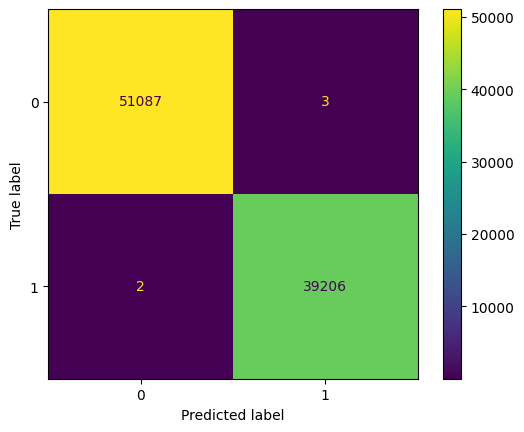

In [9]:
# Create the confusion matrix
cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();